# Keita, Alain

# CMSC 320: Data Science Final Tutorial

# Introduction:

Before Thanksgiving week, a new variant of SARS-CoV-2 (B.1.1.529 or Omnicron) was reported to the World Health Organization. It was first found in Botswana and South Africa and had made its way to the United States the week we came back from Thanksgiving break. Unlike the Delta variant, there is very little known about the severity of the Omnicron variant. There has been no information on how fast it can spread, the severity of the symptoms, or how effective vaccines are against it. 

More information about this: https://www.cdc.gov/coronavirus/2019-ncov/variants/omicron-variant.html

It seemed like the world was headed back to normal up until December. I saw the announcement of this new variant as an opportunity to identify which factors contributed to how well different countries have handled COVID-19 so far. My goal is to not only find some good predictors but also display the data science principles I've learned throughout the semester. I had never used python before, and I was impressed by how much I discovered by doing the class projects. My favorite one was the open-ended analysis of Baltimore crime data. Not following directions from start to finish and still having satisfactory results truly made me feel like a data scientist. 

In this tutorial, I will be going through the basic steps on how one can acquire some data, manipulate and visualize it, make a hypothesis, and use machine learning to prove or reject that hypothesis.

## 1) Data Collection

To start, I will rely on my intuition on what information one needs to get an idea of a country's performance against the virus in general. I learned from this class that the things you might want in a data set will not always be consolidated for you. The data collection step consists of gathering whatever we need from different sources if needed. The cleanup and merge process will be handled later. You should consider the credibility of these sources just like you would in an academic paper. A credible source allows us to worry less about the methodology behind their findings and jump right into what we need to do.

We start by retrieving recent COVID-19 data for all countries via Statista (https://www.statista.com/aboutus/). I chose to go with them because they provide easily accessible up-to-date information.  

In [48]:
# the libraries we need for all steps are imported below
import pandas as pd
import lxml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
import graphviz

# as of 12/16/2021
covid_url = "https://www.statista.com/statistics/1104709/coronavirus-deaths-worldwide-per-million-inhabitants/"

results = pd.read_html(covid_url)
results

[             Characteristic  Confirmed cases (absolute)  Cases in last 7 days  \
 0                      Peru                     2254373                 10958   
 1                  Bulgaria                      714688                  9102   
 2    Bosnia and Herzegovina                      280980                  2469   
 3                   Hungary                     1182922                 25354   
 4           North Macedonia                      219408                  2008   
 ..                      ...                         ...                   ...   
 150                   Niger                        7154                    63   
 151                    Chad                        5703                     0   
 152             New Zealand                       12986                   558   
 153                   China                      112345                   505   
 154                 Burundi                       20666                   193   
 
      Confirme

In [2]:
# we only need the first table returned by our results
covid_df = results[0]
covid_df.head()

,Characteristic,Confirmed cases (absolute),Cases in last 7 days,Confirmed deaths (absolute),Deaths in last 7 days,Daily increase (# deaths),Population (in millions),Deaths per million (total),Deaths per million (last 7 days)
0,Peru,2254373,10958,201770,391,37,32.51,6206.31,12.03
1,Bulgaria,714688,9102,29536,476,50,6.98,4234.09,68.24
2,Bosnia and Herzegovina,280980,2469,12918,138,0,3.30,3913.36,41.81
3,Hungary,1182922,25354,36429,818,0,9.77,3728.68,83.73
4,North Macedonia,219408,2008,7732,74,9,2.08,3711.14,35.52


The next data set I would like to retrieve is about vaccine status. Statista only offers that information for specific countries. After some searching, I found that the John Hopkins University Coronavirus Resource Center provides extensive data on global vaccination efforts updated every hour. 
(https://coronavirus.jhu.edu/about/how-to-use-our-data)

In [3]:
vaccine_url = "https://github.com/govex/COVID-19/blob/master/data_tables/vaccine_data/global_data/vaccine_data_global.csv"
result = pd.read_html(vaccine_url)
vaccine_df = result[0]
vaccine_df.head()

,Unnamed: 0,Province_State,Country_Region,Date,Doses_admin,People_partially_vaccinated,People_fully_vaccinated,Report_Date_String,UID
0,NaN,NaN,Afghanistan,2021-12-20,5228706.0,4397449.0,3566192.0,2021-12-20,4.0
1,NaN,NaN,Albania,2021-12-20,2251010.0,1119430.0,1008465.0,2021-12-20,8.0
2,NaN,NaN,Algeria,2021-12-20,12293060.0,6875003.0,5391232.0,2021-12-20,12.0
3,NaN,NaN,Andorra,2021-12-20,115709.0,56628.0,50551.0,2021-12-20,20.0
4,NaN,NaN,Angola,2021-12-20,10805281.0,7246240.0,3559041.0,2021-12-20,24.0


I would like to think a country's education system can tell a lot about how it can withstand a pandemic. The next piece of information I will seek to retrieve is a gloabl ranking of education.

In [4]:
url = 'https://worldpopulationreview.com/country-rankings/education-rankings-by-country'

result = pd.read_html (url)
edu_df = result[0]
edu_df.head()

,Country,Rank (2021),Rank (2020),2021 Population
0,United States,1,1.0,332915073
1,United Kingdom,2,2.0,68207116
2,Germany,3,4.0,83900473
3,Canada,4,3.0,38067903
4,France,5,5.0,65426179


## 2) Data Processing

In this section, I will tailor the data we've collected to conform to our needs. This means manipulating the each dataframe by updating/removing information that makes the material easier to comprehend. 

Inside of covid_df, I'll start by dropping some of the weekly and daily columns in favor of aggregate features like confirmed_cases and confirmed_deaths. I will also drop total_deaths column because it accounts for illnesses unrelated to COVID-19 and we don't want that to affect any potential correlation between columns. I will then update the scaled variables like 'Population(in millions)' to show the actual decimal values instead. Then I will rename the columns.

In [5]:
# drop columns
covid_df.drop (columns = ['Deaths per million (last 7 days)', 'Deaths per million (total)',
                        'Daily increase (# deaths)', 'Deaths in last 7 days'], inplace = True)
# change number format
covid_df['Population (in millions)'] = [i * 1000000 for i in covid_df['Population (in millions)'] ]

#rename remaining columns
covid_df.rename  (columns = {'Characteristic': 'country', 'Confirmed cases (absolute)': 'total_cases',
                          'Cases in last 7 days': 'cases_last_week','Confirmed deaths (absolute)': 'total_deaths',
                          'Population (in millions)':'population'}, inplace = True)

In [6]:
covid_df

,country,total_cases,cases_last_week,total_deaths,population
0,Peru,2254373,10958,201770,3.251000e+07
1,Bulgaria,714688,9102,29536,6.980000e+06
2,Bosnia and Herzegovina,280980,2469,12918,3.300000e+06
3,Hungary,1182922,25354,36429,9.770000e+06
4,North Macedonia,219408,2008,7732,2.080000e+06
...,...,...,...,...,...
150,Niger,7154,63,268,2.331000e+07
151,Chad,5703,0,181,1.595000e+07
152,New Zealand,12986,558,47,4.920000e+06
153,China,112345,505,4849,1.397720e+09


For vaccine_df, the columns with NaN will be dropped. The UID columns are only useful for representing country and city names as numbers. The data column is also not needed for our case, along with any conutry with missing information. And finally, the columns will be renamed just like previously.

In [7]:
# drop non covid columns
vaccine_df.drop (columns = ['Unnamed: 0', 'Province_State', 'Date', 'Report_Date_String', 'UID'], inplace = True)

# rename columns
vaccine_df.rename (columns = {'Country_Region': 'country', 'Doses_admin': 'doses', 
                             'People_partially_vaccinated':'partial_vaccine', 
                             'People_fully_vaccinated':'full_vaccine'}, inplace = True)

# drop NaN
vaccine_df.dropna(inplace = True)

In [8]:
vaccine_df

,country,doses,partial_vaccine,full_vaccine
0,Afghanistan,5.228706e+06,4.397449e+06,3.566192e+06
1,Albania,2.251010e+06,1.119430e+06,1.008465e+06
2,Algeria,1.229306e+07,6.875003e+06,5.391232e+06
3,Andorra,1.157090e+05,5.662800e+04,5.055100e+04
4,Angola,1.080528e+07,7.246240e+06,3.559041e+06
...,...,...,...,...
626,Vietnam,1.387726e+08,7.569740e+07,5.322472e+07
628,World,8.699468e+09,4.419346e+09,3.650035e+09
629,Yemen,7.860270e+05,5.566520e+05,3.665870e+05
630,Zambia,1.424762e+06,8.066110e+05,9.705800e+05


For our education dataframe, we only need to keep track of each country's most recent ranking.

In [9]:
edu_df.drop(columns = ['Rank (2020)', '2021 Population'], inplace = True)

# we do this so that we can merge all dataframes based on one column
edu_df.rename (columns = {'Country':'country'}, inplace = True)
edu_df

,country,Rank (2021)
0,United States,1
1,United Kingdom,2
2,Germany,3
3,Canada,4
4,France,5
...,...,...
72,El Salvador,74
73,Cambodia,75
74,Myanmar,76
75,Iraq,77


Our final step in processing data will be to merge all 3 dataframes. Since edu_df only has about half the countries compared to covid_df and vaccine_df (I'll have to keep this in mind when making assumptions later), and I deemed education ranking as a potentially important factor, I will only keep the countries that are ranked. 

In [10]:
a = set (edu_df.country.unique())
b = set (covid_df.country.unique())

# this is the set of ranked countries that are either not represented or misnamed in covid_df
a-b

{'Denmark',
 'France',
 'Myanmar',
 'Netherlands',
 'United Kingdom',
 'United States'}

In [11]:
# b
# after looking at the list of countries in covid_df, I saw that Myanmar was missing 
# other countries had a subscript in their spelling

# I will rename those countries, and perform the set operation to make sure nothing was left out

covid_df.replace ('Denmark¹', 'Denmark',inplace = True)
covid_df.replace ('France¹', 'France', inplace = True)
covid_df.replace ('Netherlands¹', 'Netherlands', inplace = True)
covid_df.replace ('United Kingdom¹', 'United Kingdom', inplace = True)
covid_df.replace ('USA¹', 'United States', inplace = True)

#a-b

In [12]:
# now we drop every row with an unranked country
rows_to_drop = []

for idx,row in covid_df.iterrows():
    if row['country'] not in edu_df['country'].unique():
        rows_to_drop.append (idx)
        
        
covid_df.drop(rows_to_drop, inplace = True)

In [13]:
covid_df

,country,total_cases,cases_last_week,total_deaths,population
0,Peru,2254373,10958,201770,3.251000e+07
1,Bulgaria,714688,9102,29536,6.980000e+06
3,Hungary,1182922,25354,36429,9.770000e+06
8,Romania,1793149,6310,57696,1.936000e+07
9,Brazil,22177059,29583,616457,2.110500e+08
...,...,...,...,...,...
117,Australia,230768,10213,2106,2.536000e+07
118,South Korea,523088,40778,4293,5.171000e+07
131,Uzbekistan,195747,1191,1436,3.358000e+07
152,New Zealand,12986,558,47,4.920000e+06


I will apply the same technique to vaccine_df before I can merge all three sets. 

In [14]:
c = set (vaccine_df.country.unique())
a-c

{'Myanmar', 'South Korea', 'United States'}

In [15]:
# looking at the set of coutries in vaccine_df, United States was abbreviated to US 
# South Korea was dropped because of missing values while Myanmar was never included

vaccine_df.replace ('US', 'United States', inplace = True)

rows_to_drop2 = []
for idx,row in vaccine_df.iterrows():
    if row['country'] not in edu_df['country'].unique():
        rows_to_drop2.append (idx)
        
        
vaccine_df.drop (rows_to_drop2, inplace = True)

In [16]:
# final merge

final_df = edu_df.merge (pd.merge (covid_df, vaccine_df, on = 'country'), on = 'country' )
final_df

,country,Rank (2021),total_cases,cases_last_week,total_deaths,population,doses,partial_vaccine,full_vaccine
0,United States,1,49703016,637381,793713,328240000.0,495101938.0,241571084.0,203926479.0
1,United Kingdom,2,10757841,302425,145982,66830000.0,128469665.0,51463255.0,47009608.0
2,Germany,3,6546010,326751,105758,83130000.0,142073580.0,60992596.0,58444931.0
3,Canada,4,1841672,20979,29964,37590000.0,65188844.0,31443084.0,29285689.0
4,France,5,7827502,325955,114516,67060000.0,116208558.0,52430750.0,48496460.0
...,...,...,...,...,...,...,...,...,...
70,Ecuador,73,533190,3841,33558,17370000.0,26588158.0,14016690.0,12071652.0
71,El Salvador,74,121127,1324,3795,6450000.0,9466222.0,4465139.0,4130209.0
72,Cambodia,75,120355,83,2985,16490000.0,29803062.0,14224202.0,13590650.0
73,Iraq,77,2087837,2876,23978,39310000.0,13360483.0,8111496.0,5241122.0


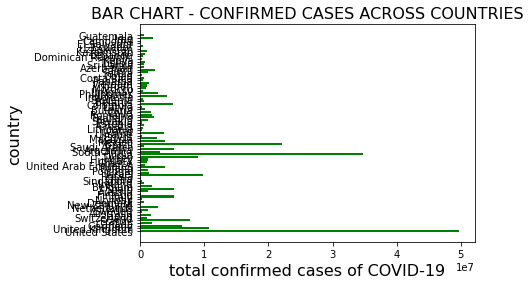

In [17]:
fig  = plt.figure()

y = final_df['total_cases']
x = final_df['country']

plt.barh( x, y, color = 'green' )

plt.xlabel('total confirmed cases of COVID-19', fontsize = 16)
plt.ylabel('country', fontsize = 16)
plt.title('BAR CHART - CONFIRMED CASES ACROSS COUNTRIES', fontsize = 16)
plt.show()

The United States have far way more cases than any other country. This could be due to population numbers. Bar plots allow me to do a multivariate analysis, so I will include the population of each country as a different color next to the green bars.

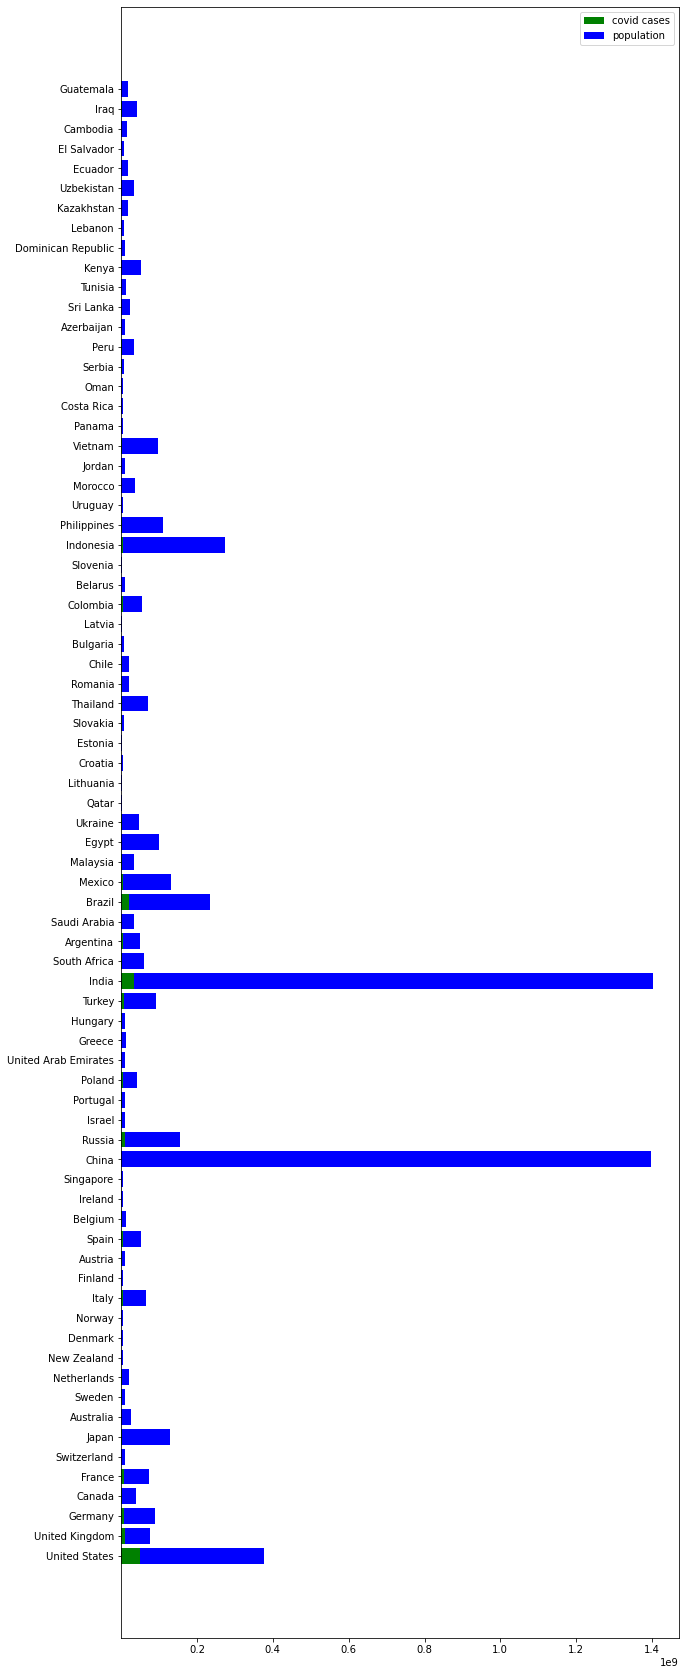

In [18]:
bar1 = np.arange(len(final_df['country']))
bar2 = [i + 2.5 for i in bar1]

plt.rcParams["figure.figsize"] = (10,30)

plt.barh( x, y, color = 'green', label = 'covid cases' )
plt.barh( x, final_df['population'], color = 'blue', label = 'population' , left = y )
plt.legend()
plt.show()


The graph above is not as insightful as I had hoped. It does not strongly support that population has a relationship with total_cases. I see that countries like China, India, and the US have large population counts in proportion to the number of cases confirmed. I will use a heatmap next to examine the relationships of all columns with each other. To do so, I will need to create a correlation matrix using the DataFrame.corr() function and pass it as a parameter to a seaborn function.

In [19]:
corr = final_df.corr()
corr

,Rank (2021),total_cases,cases_last_week,total_deaths,population,doses,partial_vaccine,full_vaccine
Rank (2021),1.000000,-0.287522,-0.474375,-0.227931,-0.139479,-0.164582,-0.156158,-0.166773
total_cases,-0.287522,1.000000,0.701071,0.926857,0.477607,0.347670,0.401159,0.327228
cases_last_week,-0.474375,0.701071,1.000000,0.607156,0.111075,0.105917,0.102075,0.098500
total_deaths,-0.227931,0.926857,0.607156,1.000000,0.405705,0.298459,0.342748,0.284761
population,-0.139479,0.477607,0.111075,0.405705,1.000000,0.952025,0.981631,0.940758
doses,-0.164582,0.347670,0.105917,0.298459,0.952025,1.000000,0.992552,0.999185
partial_vaccine,-0.156158,0.401159,0.102075,0.342748,0.981631,0.992552,1.000000,0.987590
full_vaccine,-0.166773,0.327228,0.098500,0.284761,0.940758,0.999185,0.987590,1.000000


<AxesSubplot:>

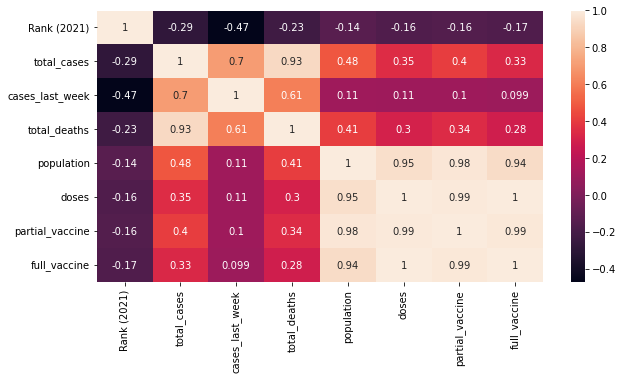

In [20]:
plt.figure(figsize = (10, 5))
sns.heatmap(corr, annot = True)

What I found from the heatmap is not assuring. For one, it shows that country's educational ranking has a nagative linear relationship with any other column in the dataframe (less than 0). Additionally, all the original columns from covid_df (cases, deaths) have a weak relationship with the vaccine_df columns. This makes does not sense to me, so I had to think of where I might have made an error. Perhaps when I manipulated the dataframe to only include the 70 countries that were ranked, I tampered with the results I was expecting. This shows that the data science pipeline is also not a linear process. Ideally, I would have to collect additional data and apply more carefulness in the manipulation. But we found so far only tells that the linear relationships are weak. In the next section, I will use a decision tree algorithm in an attempt to predict total deaths, and also learn anything new about our dataframe.

## 4) Machine Learning

The decision tree algorithm is intutively easy to follow and understand. To predict a particular output from input data, you stat at the root and follow branches along the way making a decision at every level. I chose this algoritm for its simplicity and the chance to gain insight on what problems I have with my dataframe. The relationship between columns seem complex and non-linear. Essentially, I want to be able to accurately predict what is correlated with total deaths.

In [47]:
# conda install -c anaconda python-graphviz

X = final_df.drop (columns = ['total_deaths', 'country']) # everything except total_deaths, and country values that are strings 
y = final_df['total_deaths'] # what we want to predict

# train the model, split 80% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

# compare predicted values and actual values
pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

,Actual,Predicted
52,50280,27839.0
71,3795,4113.0
1,145982,283815.0
32,8853,14614.0
70,33558,14614.0
66,4218,21060.0
16,88381,134831.0
44,57696,38600.0
55,11982,36429.0
37,96695,129107.0


In [49]:
# evaluating the algorithm

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 58173.13333333333
Mean Squared Error: 8234283578.866667
Root Mean Squared Error: 90742.95332898674


## 5) Conclusion

Our algorithm does a poor job at predicting outcomes. On average, the predicted value's distance from the true value is 58173! This could mean that certain features I removed were important were important for the peformance of the model. It could also mean that I need more information in order to accurately predict any COVID-related data. If anything, this tutorial serves as an indication that infectious disease prevention using statitical models is more complicated than I assumed.